In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

In [4]:
# Define dataset paths (update these paths to your dataset folder in Kaggle)
base_dir = "/kaggle/input/resnet50-model"

# Dataset directories
pneumonia_dir = os.path.join(base_dir, "Split_Pneumonia", "Split_Pneumonia" )
covid19_dir = os.path.join(base_dir, "Split_COVID19", "Split_COVID19")
tuberculosis_dir = os.path.join(base_dir, "Split_Tuberculosis", "Split_Tuberculosis")

# Print directories to verify structure
print("Pneumonia:", pneumonia_dir)
print("COVID-19:", covid19_dir)
print("Tuberculosis:", tuberculosis_dir)


Pneumonia: /kaggle/input/resnet50-model/Split_Pneumonia/Split_Pneumonia
COVID-19: /kaggle/input/resnet50-model/Split_COVID19/Split_COVID19
Tuberculosis: /kaggle/input/resnet50-model/Split_Tuberculosis/Split_Tuberculosis


Define Data Generators with Augmentation

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define data generators
def get_data_generators(dataset_path, batch_size=32, target_size=(224, 224)):
    """
    Define data generators for training, validation, and test sets with augmentation.
    """
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_gen = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'val'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen, test_gen

Build the ResNet50 Model

In [8]:
# Build ResNet50 model
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=3):
    """
    Builds and returns a ResNet50 model with a custom top layer.
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    base_model.trainable = False  # Freeze the base model
    return model

# Compile model
def compile_model(model):
    """
    Compiles the model with Adam optimizer and categorical crossentropy loss.
    """
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Build and compile models for all datasets
model_pneumonia = build_resnet50_model(num_classes=3)
model_covid19 = build_resnet50_model(num_classes=3)
model_tuberculosis = build_resnet50_model(num_classes=3)

compile_model(model_pneumonia)
compile_model(model_covid19)
compile_model(model_tuberculosis)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Define Training Function

In [13]:
def train_model(dataset_name, dataset_path, epochs=10, batch_size=32):
    print(f"\nTraining on {dataset_name} dataset...\n")
    
    # Get data generators
    train_gen, val_gen, test_gen = get_data_generators(dataset_path, batch_size=batch_size)
    num_classes = len(train_gen.class_indices)
    
    # Build the ResNet50 model
    model = build_resnet50_model(num_classes=num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        f"{dataset_name}_ResNet50.keras", 
        save_best_only=True, 
        monitor='val_accuracy', 
        mode='max',
        verbose=1
    )
    early_stop = EarlyStopping(
        monitor='val_accuracy', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )
    
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"\nTest Accuracy for {dataset_name}: {test_acc * 100:.2f}%")
    
    return history, model, test_gen

Train the Model on All Datasets

In [14]:
import tensorflow as tf 
history_pneumonia, model_pneumonia, test_gen_pneumonia = train_model(
    dataset_name="Pneumonia", 
    dataset_path=pneumonia_dir, 
    epochs=10, 
    batch_size=32
)
history_covid19, model_covid19, test_gen_covid19 = train_model(
    dataset_name="COVID-19", 
    dataset_path=covid19_dir, 
    epochs=10, 
    batch_size=32
)
history_tuberculosis, model_tuberculosis, test_gen_tuberculosis = train_model(
    dataset_name="Tuberculosis", 
    dataset_path=tuberculosis_dir, 
    epochs=10, 
    batch_size=32
)


Training on Pneumonia dataset...

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Epoch 1/10
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.7133 - loss: 0.6262
Epoch 1: val_accuracy improved from -inf to 0.72991, saving model to Pneumonia_ResNet50.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 576ms/step - accuracy: 0.7135 - loss: 0.6255 - val_accuracy: 0.7299 - val_loss: 0.4923
Epoch 2/10
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7656 - loss: 0.4679
Epoch 2: val_accuracy improved from 0.72991 to 0.81880, saving model to Pneumonia_ResNet50.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 540ms/step - accuracy: 0.7657 - loss: 0.4679 - val_accuracy: 0.8188 - val_loss: 0.4155
Epoch 3/10
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.7962 - loss: 0.4258
Epoch 3: val_accuracy improved from 0.81880 to 0.83932, saving model to Pneumonia_ResNet50.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 543ms/step - acc

Analyze Results

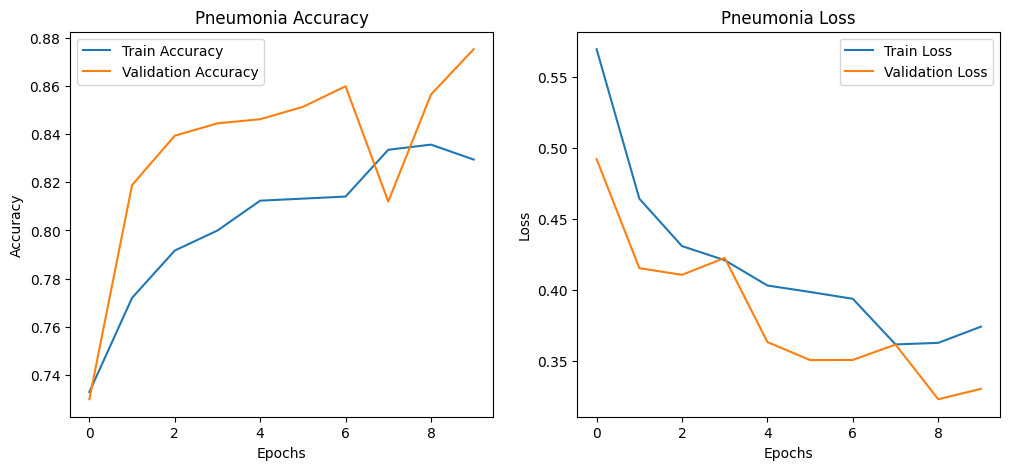

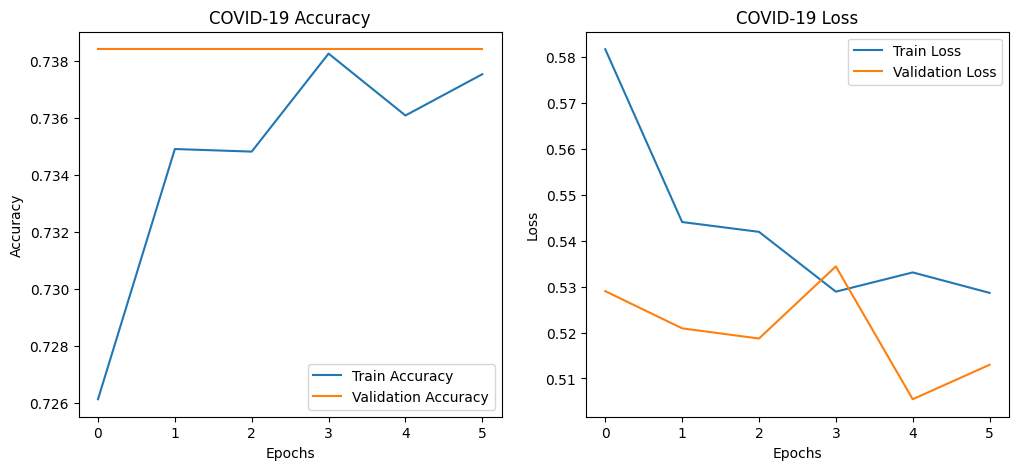

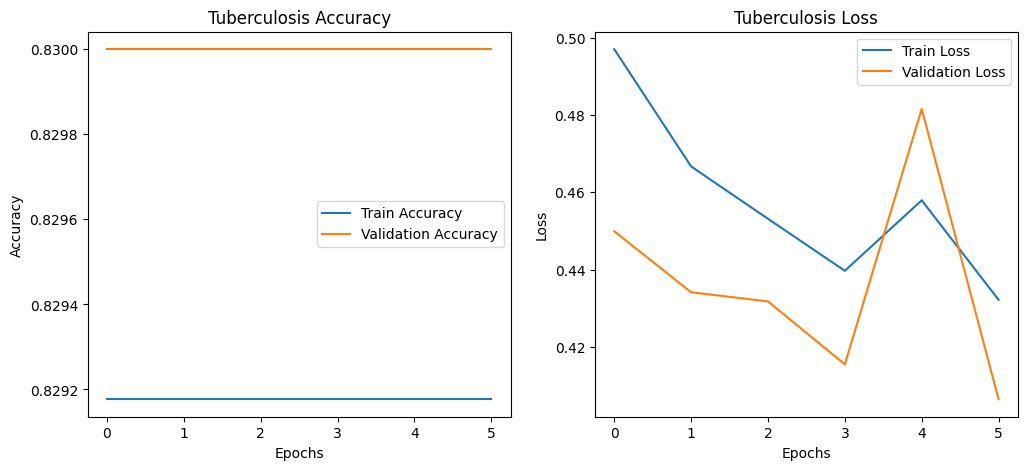

In [15]:
def plot_history(history, dataset_name):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{dataset_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
plot_history(history_pneumonia, "Pneumonia")
plot_history(history_covid19, "COVID-19")
plot_history(history_tuberculosis, "Tuberculosis")

Classification Reports and Confusion Matrices

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step
Classification Report for Pneumonia:

                              precision    recall  f1-score   support

   normal x-ray chest images       0.80      0.65      0.72       159
pneumonia x-ray chest images       0.88      0.94      0.91       428

                    accuracy                           0.86       587
                   macro avg       0.84      0.80      0.81       587
                weighted avg       0.86      0.86      0.86       587



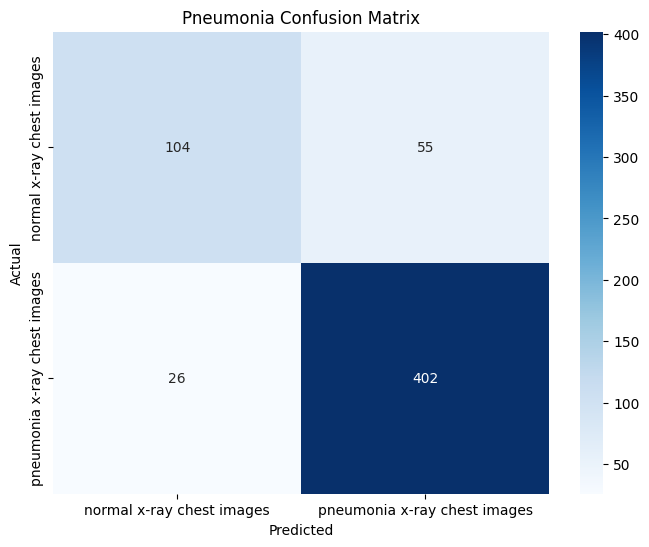

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
Classification Report for COVID-19:

                            precision    recall  f1-score   support

      covid19 x-ray images       0.00      0.00      0.00       363
normal chest  x-ray images       0.74      1.00      0.85      1020

                  accuracy                           0.74      1383
                 macro avg       0.37      0.50      0.42      1383
              weighted avg       0.54      0.74      0.63      1383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


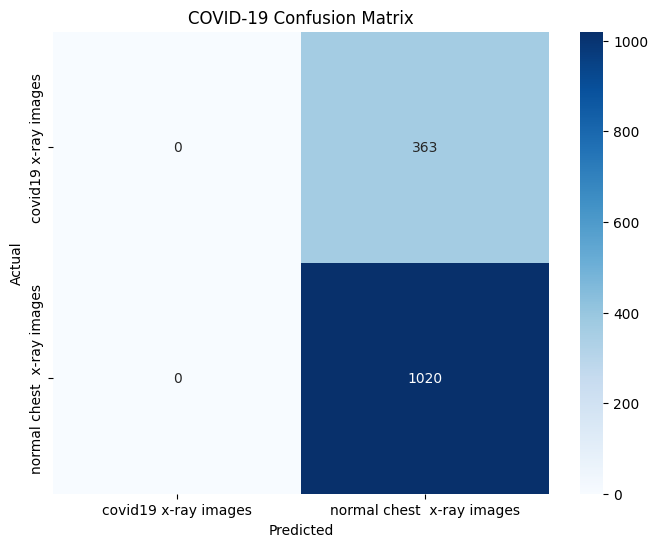

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Classification Report for Tuberculosis:

                                 precision    recall  f1-score   support

      normal x-ray chest images       0.00      0.00      0.00        52
tuberculosis x-ray chest images       0.83      1.00      0.91       250

                       accuracy                           0.83       302
                      macro avg       0.41      0.50      0.45       302
                   weighted avg       0.69      0.83      0.75       302



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


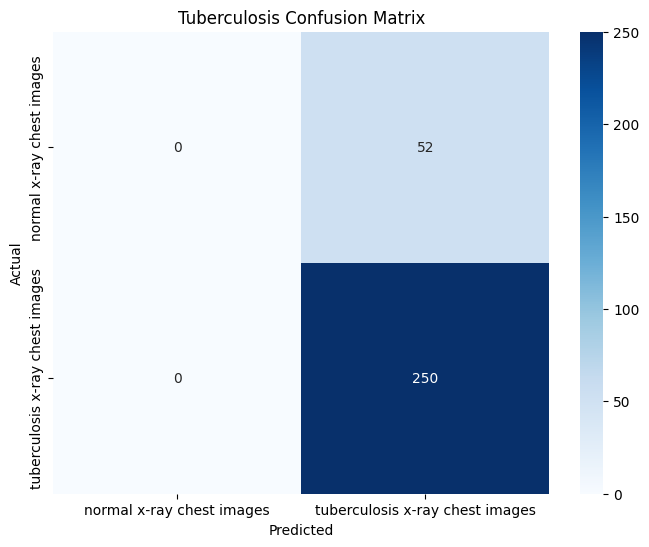

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(test_gen, model, dataset_name):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    class_labels = list(test_gen.class_indices.keys())
    
    # Classification Report
    print(f"Classification Report for {dataset_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate each model
evaluate_model(test_gen_pneumonia, model_pneumonia, "Pneumonia")
evaluate_model(test_gen_covid19, model_covid19, "COVID-19")
evaluate_model(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

Generate and Analyze Precision-Recall and ROC Curves

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step

Precision-Recall Curve for Pneumonia:


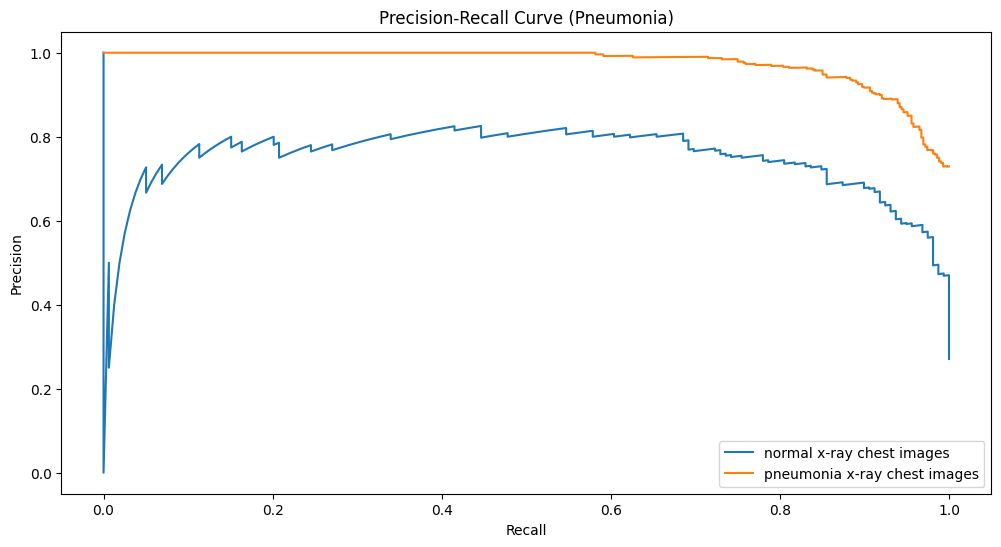


ROC Curve for Pneumonia:


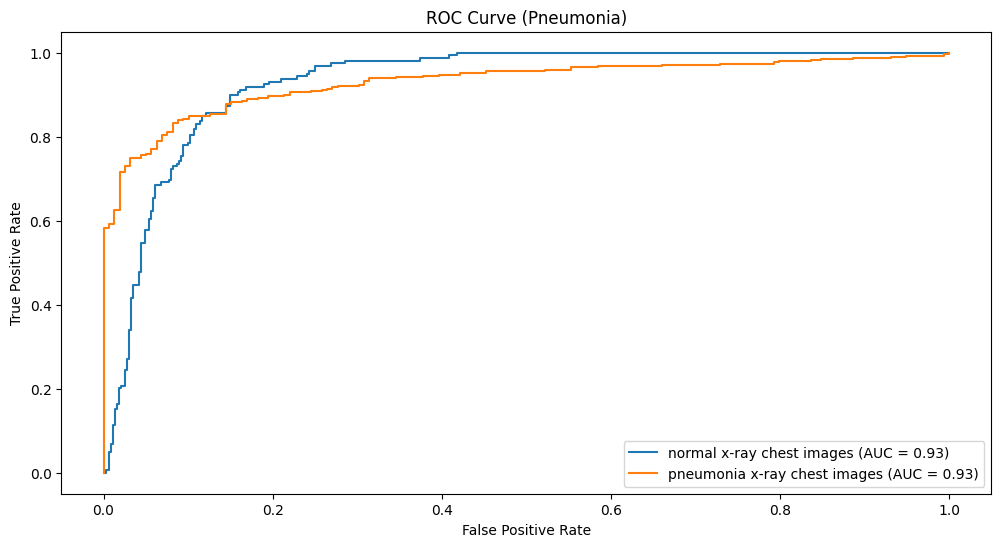

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step

Precision-Recall Curve for COVID-19:


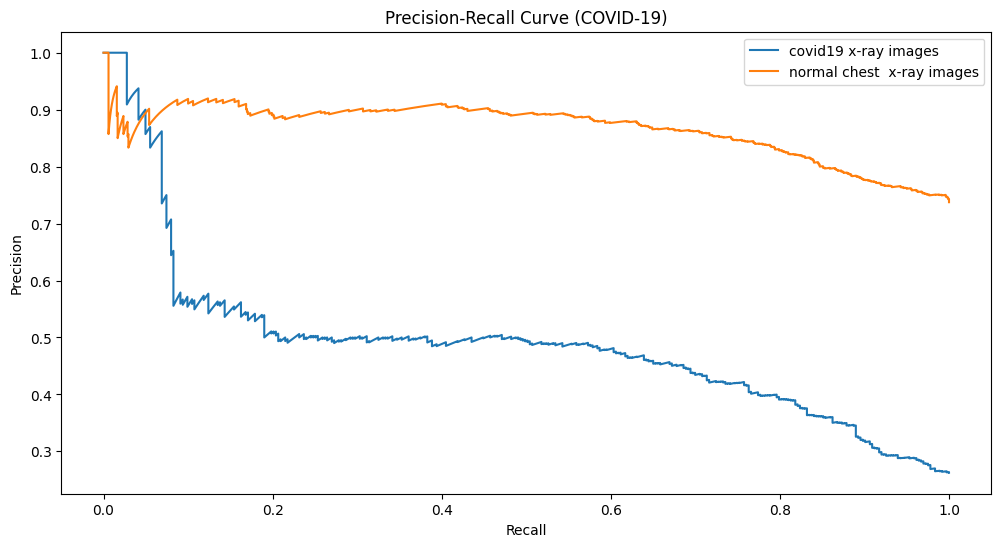


ROC Curve for COVID-19:


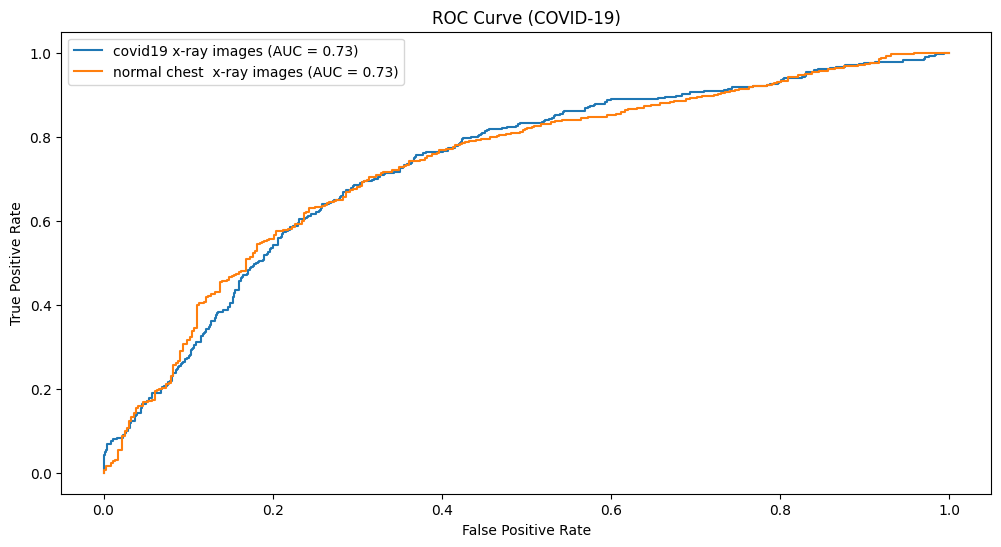

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

Precision-Recall Curve for Tuberculosis:


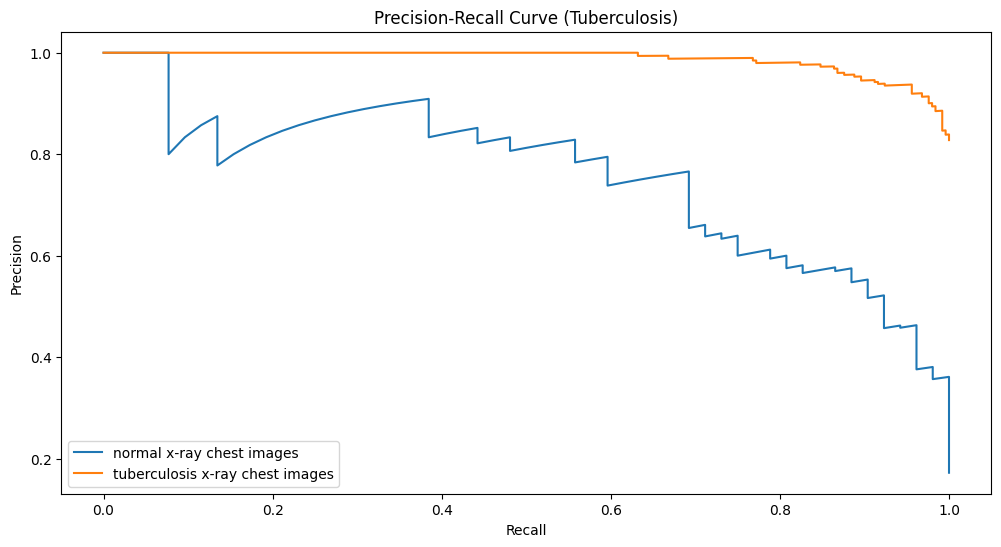


ROC Curve for Tuberculosis:


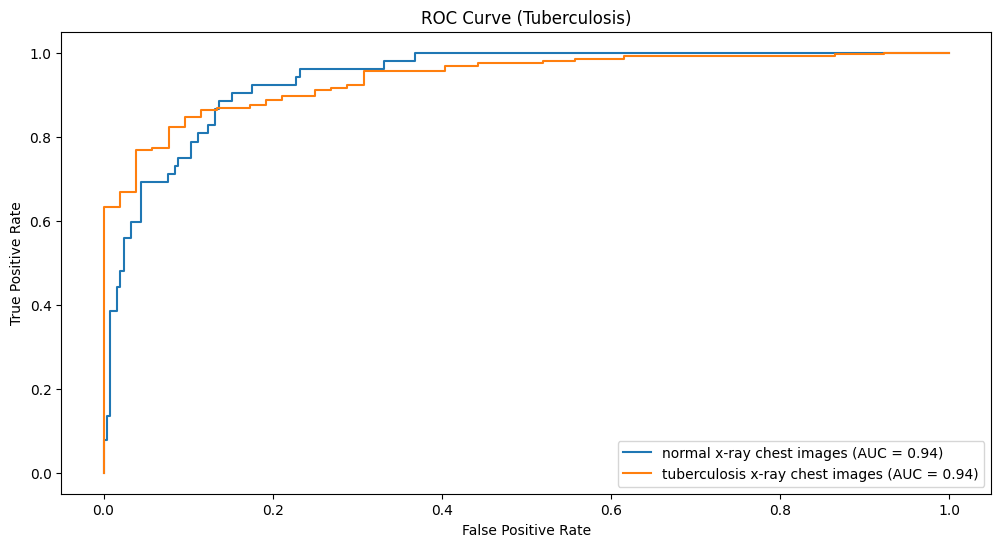

In [19]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
def plot_precision_recall_and_roc(test_gen, model, dataset_name):
    # Get true labels and predicted probabilities
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    
    # Precision-Recall Curve for each class
    print(f"\nPrecision-Recall Curve for {dataset_name}:")
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(test_gen.class_indices.keys()):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_name}')
    plt.title(f'Precision-Recall Curve ({dataset_name})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    # ROC Curve for each class
    print(f"\nROC Curve for {dataset_name}:")
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(test_gen.class_indices.keys()):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.title(f'ROC Curve ({dataset_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
# Generate Precision-Recall and ROC Curves for Pneumonia
plot_precision_recall_and_roc(test_gen_pneumonia, model_pneumonia, "Pneumonia")

# Generate Precision-Recall and ROC Curves for COVID-19
plot_precision_recall_and_roc(test_gen_covid19, model_covid19, "COVID-19")

# Generate Precision-Recall and ROC Curves for Tuberculosis
plot_precision_recall_and_roc(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

CALIBRATION CURVE

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step


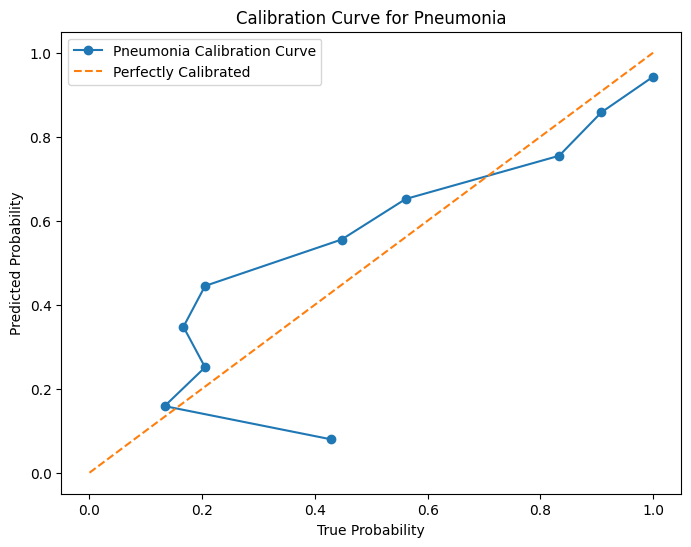

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step


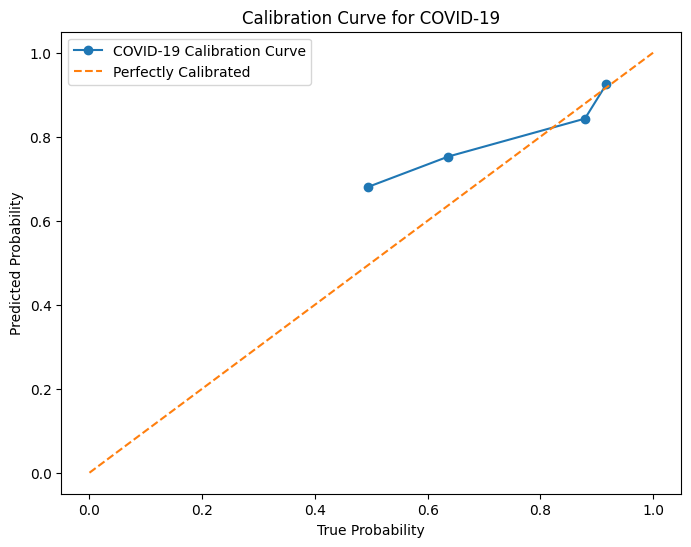

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


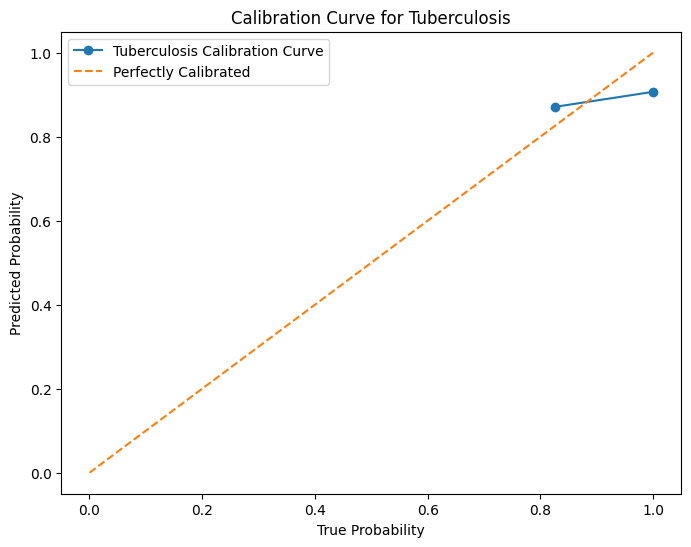

In [20]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(test_gen, model, dataset_name):
    # Get true labels and predicted probabilities
    y_true = test_gen.classes
    y_pred = model.predict(test_gen)  # Use predict to get probabilities

    # For multi-class classification, extract probabilities for each class
    # If it's binary classification, y_pred[:, 1] will give you the probability of the positive class
    if y_pred.shape[1] > 2:  # Multi-class classification
        y_pred = y_pred[:, 1]  # Modify this line for specific classes if needed
    else:
        y_pred = y_pred[:, 1]  # For binary, take the second column for the positive class
    
    # Compute the calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    
    # Plot the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(prob_true, prob_pred, marker='o', label=f'{dataset_name} Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('True Probability')
    plt.ylabel('Predicted Probability')
    plt.title(f'Calibration Curve for {dataset_name}')
    plt.legend()
    plt.show()

# Calibration Curve for each dataset
plot_calibration_curve(test_gen_pneumonia, model_pneumonia, "Pneumonia")
plot_calibration_curve(test_gen_covid19, model_covid19, "COVID-19")
plot_calibration_curve(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

ACCURACY PER CLASS

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

def accuracy_per_class(test_gen, model, dataset_name):
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy per class
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print(f"Accuracy per Class for {dataset_name}:")
    for i, label in enumerate(test_gen.class_indices.keys()):
        print(f"Accuracy for {label}: {class_accuracy[i]:.2f}")

# Accuracy per class for each dataset
accuracy_per_class(test_gen_pneumonia, model_pneumonia, "Pneumonia")
accuracy_per_class(test_gen_covid19, model_covid19, "COVID-19")
accuracy_per_class(test_gen_tuberculosis, model_tuberculosis, "Tuberculosis")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step
Accuracy per Class for Pneumonia:
Accuracy for normal x-ray chest images: 0.65
Accuracy for pneumonia x-ray chest images: 0.94
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
Accuracy per Class for COVID-19:
Accuracy for covid19 x-ray images: 0.00
Accuracy for normal chest  x-ray images: 1.00
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Accuracy per Class for Tuberculosis:
Accuracy for normal x-ray chest images: 0.00
Accuracy for tuberculosis x-ray chest images: 1.00
